## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_diagonal_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/diagonal/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


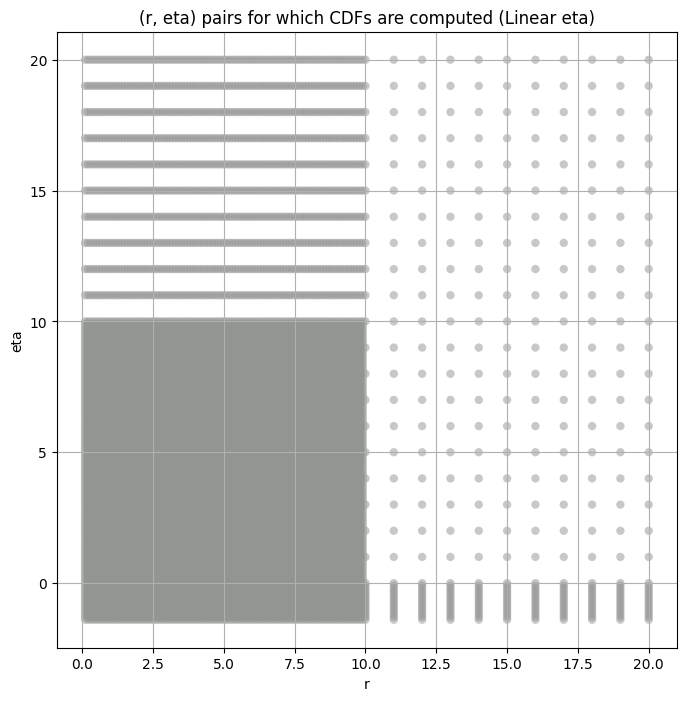

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1722.312600  1556.518900  1894.537500   0.296366   -0.065850   
3       381.132320   358.688500   404.139500   1.417218    1.040942   
4        69.626785    65.514710    73.893234   3.422446    2.709257   
5        11.818949    11.006219    12.672133   5.558610    4.478826   
6         1.986774     1.822651     2.164862   9.345805    6.891265   
7         0.351204     0.315624     0.395142  16.423952   10.114853   
8         0.079105     0.068840     0.093627  32.942100   15.381708   
9         0.018559     0.015405     0.023803  68.993180   25.134613   

       kurt_upper  total_samples  
layer                             
2        0.712099         1604.0  
3        1.866860         6416.0  
4        4.306627        25664.0  
5        7.095064       102656.0  
6       14.922341       410624.0  
7       44.308070      1642496.0  
8      111.845790      6569984.0  
9      257.763280     26279936.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      1722.312600    1722.312622     1396.826904     1211.505615   
3       381.132320     381.132324      345.089691      322.453033   
4        69.626785      69.626785       66.018753       63.760288   
5        11.818949      11.818949       11.545095       11.354646   
6         1.986774       1.986774        1.918568        1.877171   
7         0.351204       0.351204        0.333988        0.324410   
8         0.079105       0.079105        0.073282        0.070439   
9         0.018559       0.018559        0.016561        0.015656   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         1063.938721       936.961548       731.001892       573.413452   
3          304.098175       288.096954       261.201385       238.499084   
4           61.929276        60.331051        57.543274        55.103794   
5           11.190375        11.042186        10.783710        10.552773   
6            1.842241         1.811407         1.757434         1.710397   
7            0.316571         0.309730         0.297973         0.287956   
8            0.068165         0.066224         0.062946         0.060193   
9            0.014951         0.014359         0.013385         0.012592   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           447.194946       344.797821       262.871918       102.526947  
3           218.677826       201.238022       185.584320       147.663376  
4            52.930256        50.952789        49.129696        44.418194  
5            10.345102        10.154406         9.977174         9.501317  
6             1.668306         1.629759         1.594088         1.500121  
7             0.279110         0.271107         0.263777         0.244748  
8             0.057799         0.055674         0.053756         0.048900  
9             0.011918         0.011331         0.010812         0.009538

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.02217098407869983 1722.3126


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.03458031330125577 1396.8269


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.049769717779243994 1211.5056


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.06488252504484515 1063.9387


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.07916989712042899 936.96155


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.10543454901363591 731.0019


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.1284257007789189 573.41345


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.15391959350304152 447.19495


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.1788319334239924 344.79782


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.20573192548472263 262.87192


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.2949660502507745 102.52695
Number of samples: 1604, Without approximation : 1604.0


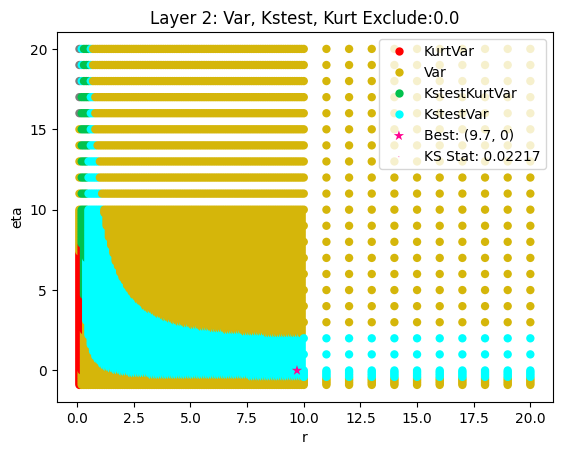

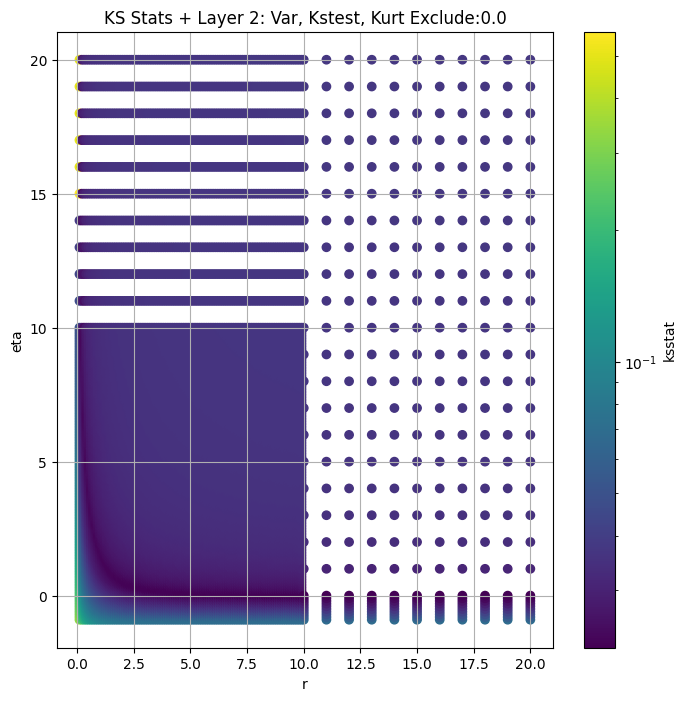

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.010336666915389425 381.13232


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.01221416590789215 345.0897


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.017171611051332247 322.45303


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.021394589526550045 304.09818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.02559402384517362 288.09695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.03383989682585431 261.2014


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.041569947423226394 238.49908


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.04885700503594781 218.67783


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.05543420940315813 201.23802


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.062100110607754 185.58432


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.08177828450802938 147.66338
Number of samples: 6416, Without approximation : 6416.0


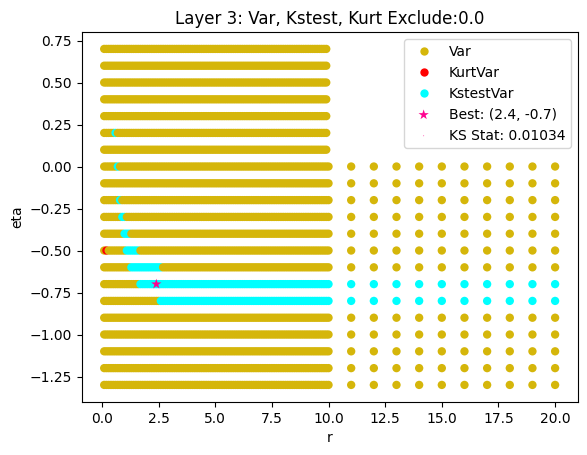

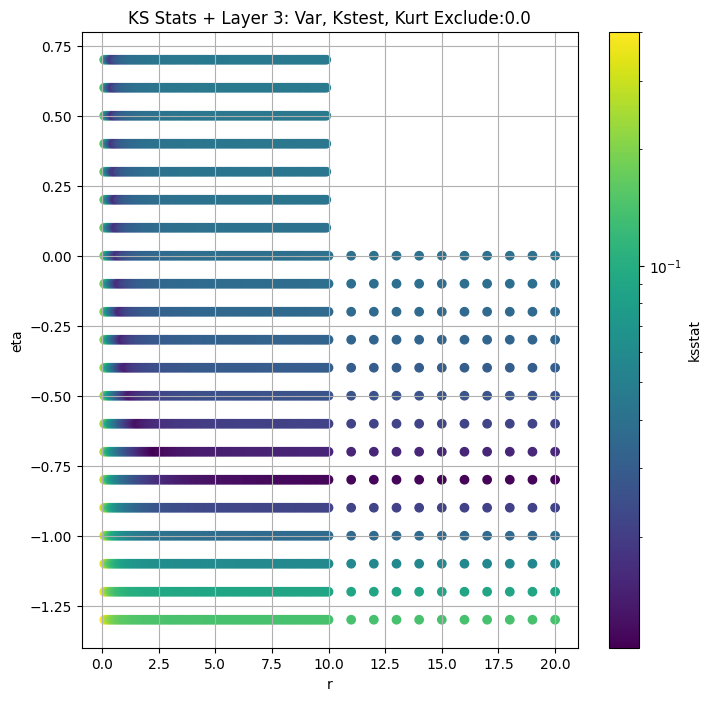

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.00408468628797487 69.626785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.0043487862782625175 66.01875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.00558155925860504 63.76029


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.006946006198011223 61.929276


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.008248417269097863 60.33105


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.011074837078827282 57.543274


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.013740027608183492 55.103794


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.01618892292219598 52.930256


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.018451763825026335 50.95279


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.020566915260317287 49.129696


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.026829245045641437 44.418194
Number of samples: 25664, Without approximation : 25664.0


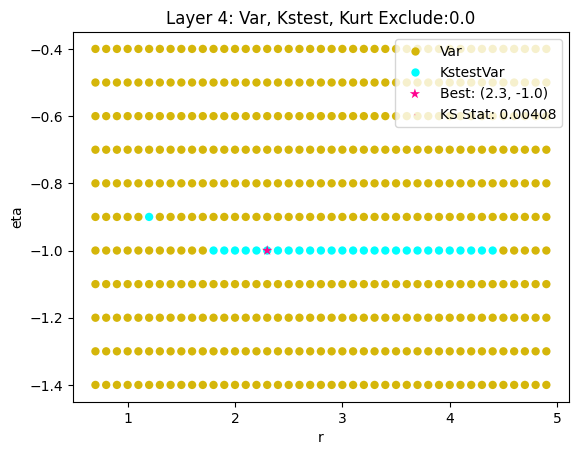

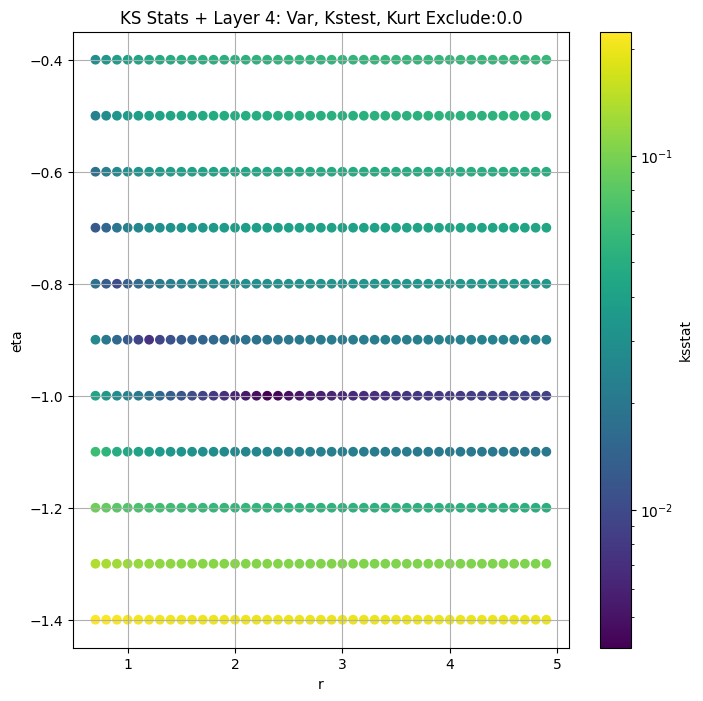

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.008532003164847368 11.818949


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.008084421050120083 11.545095


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.008341621599895266 11.354646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.007897534484543556 11.190375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.008102899677956965 11.042186


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.00790836482962487 10.78371


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.00777035305487872 10.552773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.007683069562610445 10.345102


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.007627721145023858 10.154406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.00810532573472806 9.977174


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.009536750365111132 9.501317
Number of samples: 100000, Without approximation : 102656.0


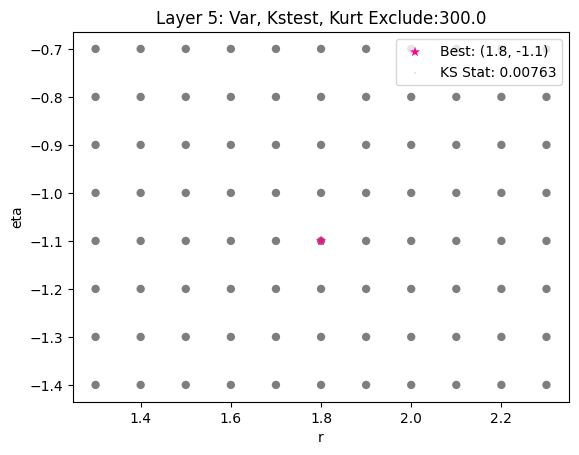

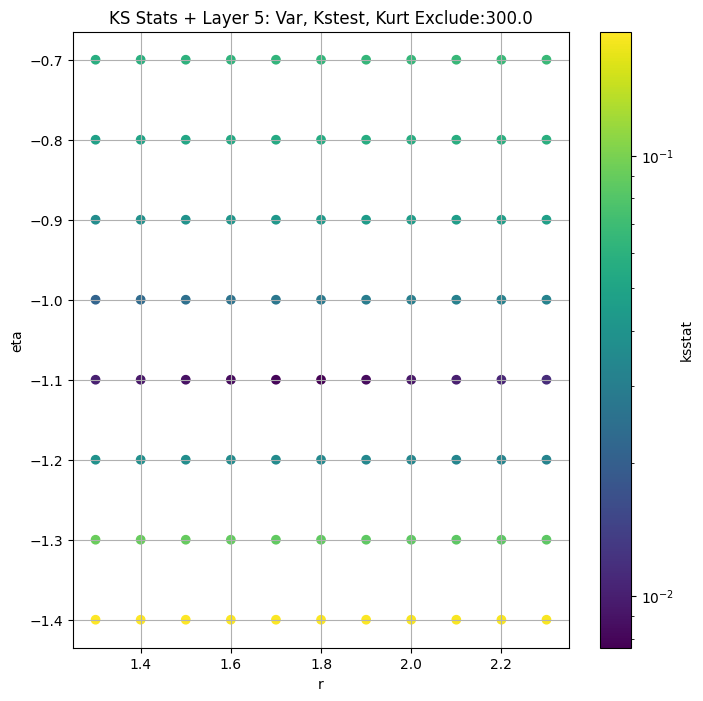

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.011497412024477183 1.9867742


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.012402312702817442 1.9185679


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.012971857937168818 1.8771709


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.012633271208415009 1.8422407


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.01175606518567196 1.8114073


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.010177335074652294 1.7574345


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.0096649923257065 1.7103968


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.010936171432447545 1.6683064


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.012163130883177525 1.6297592


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.01234210401877811 1.5940883


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.013399537485991903 1.500121
Number of samples: 100000, Without approximation : 410624.0


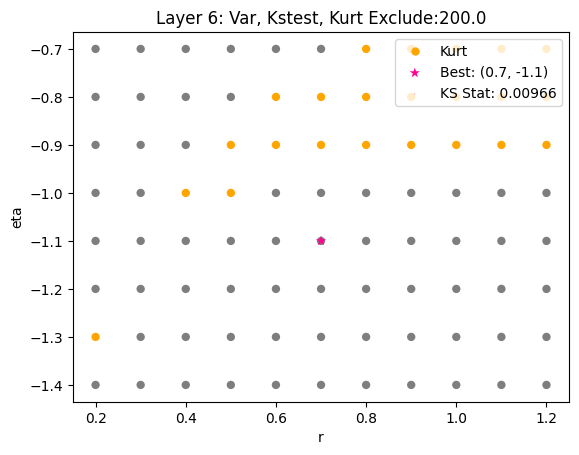

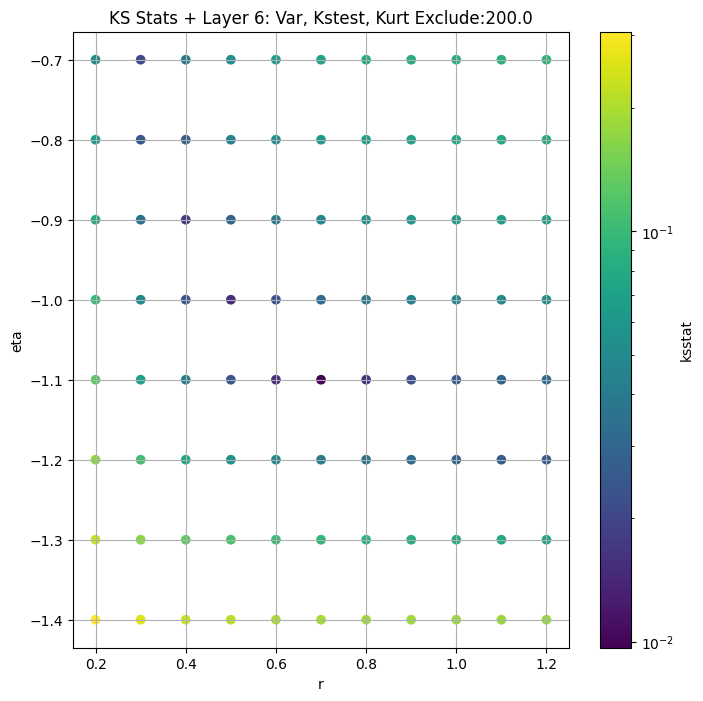

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.014614427357760529 0.35120443


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.013590395848246284 0.33398822


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.013142693678917239 0.32440972


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.014197290986227906 0.31657094


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.015145811569780676 0.30973005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.01501430461807085 0.29797325


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.014315389644325105 0.28795582


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.013682072132281564 0.27911016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.014016526957969455 0.2711065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.015219119986796315 0.263777


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.013798970140904476 0.24474755
Number of samples: 100000, Without approximation : 1642496.0


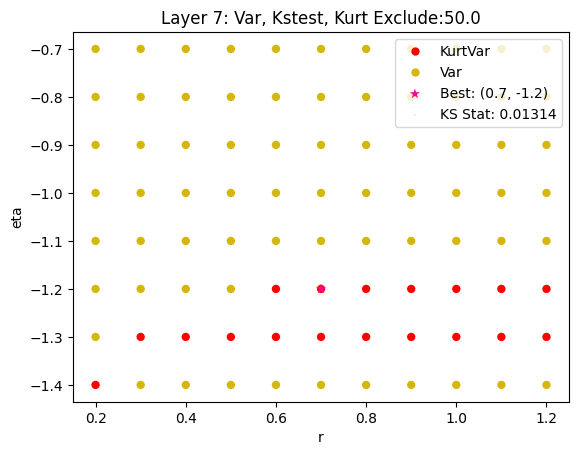

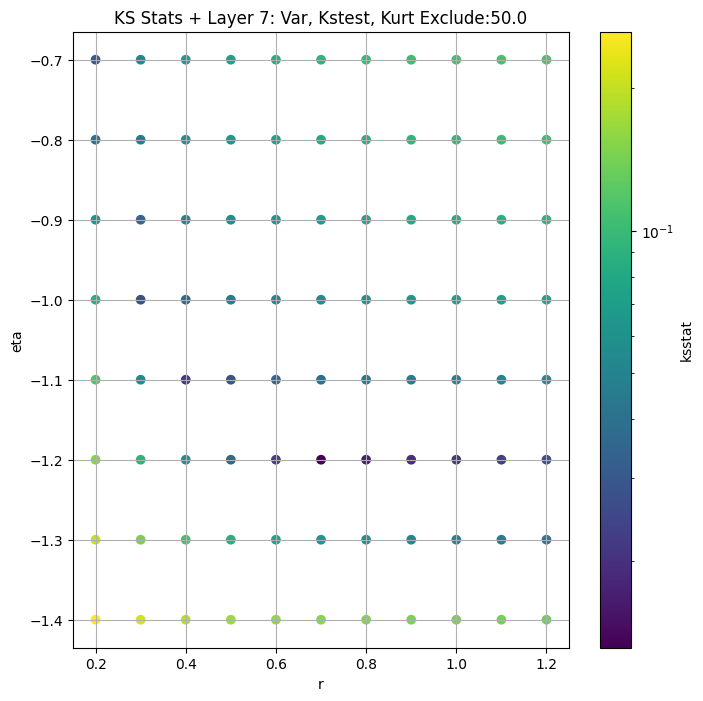

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.006186776163053964 0.07910506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.007014698934444952 0.07328156


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.008972696467805852 0.07043942


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.010858519378839526 0.06816514


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.011614724368601448 0.066224046


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.012266020968670577 0.06294597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.011213548540518592 0.060192715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.0095299176576073 0.057799023


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.008168177286218492 0.055674


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007979925678424586 0.053755675


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010613913209398348 0.048899572
Number of samples: 100000, Without approximation : 6569984.0


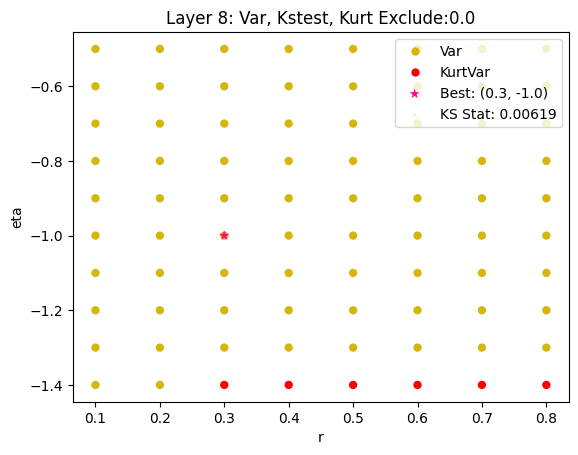

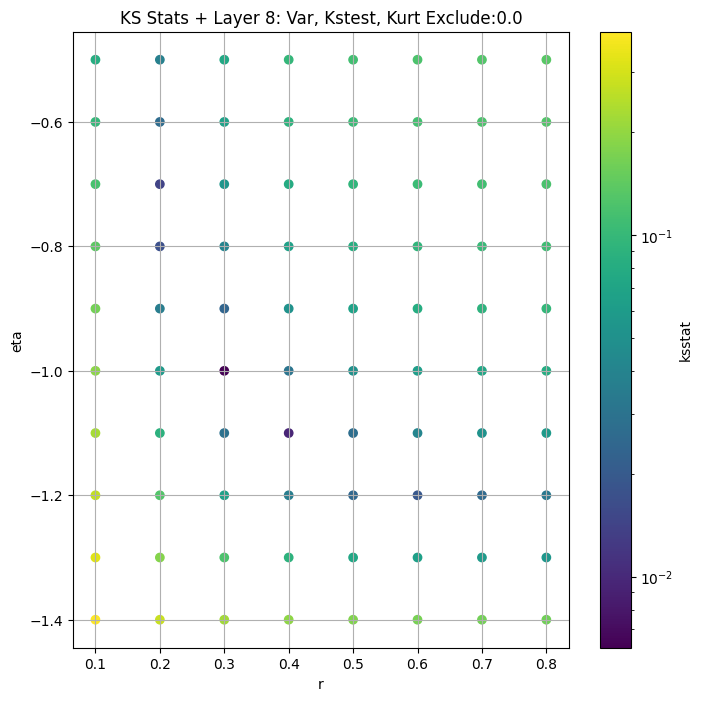

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.016438595836472003 0.018558972


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.01826184362306904 0.016560612


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.017364810770970074 0.015655825


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.014618086742856473 0.014950745


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.013971502143803716 0.014358852


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.016017647369921062 0.013385471


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.014401354107079323 0.012592021


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.015728479661749395 0.011918047


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.01715565777561523 0.011331101


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.016719787860198565 0.010811665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.018735936524690522 0.009537926
Number of samples: 100000, Without approximation : 26279936.0


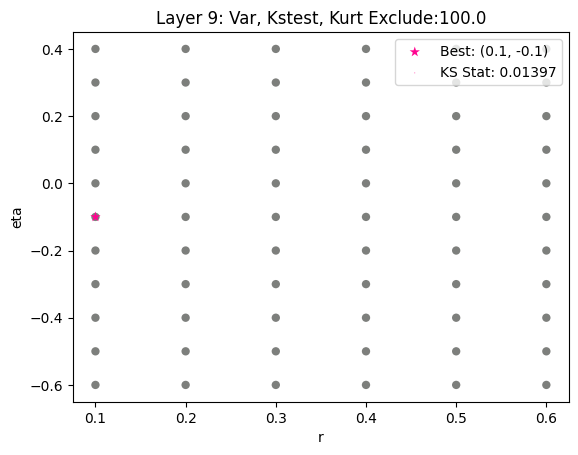

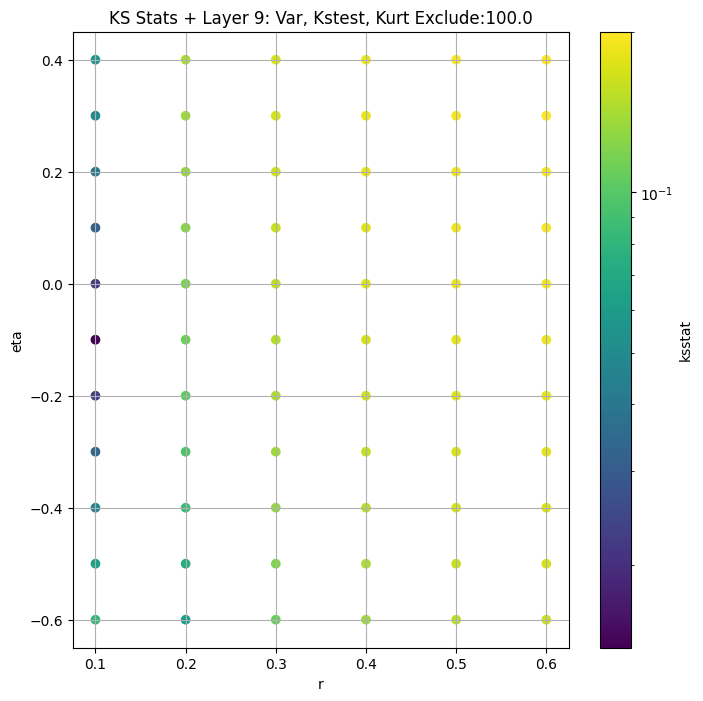

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1722.312600  1556.518900  1894.537500   0.296366   -0.065850   
3       381.132320   358.688500   404.139500   1.417218    1.040942   
4        69.626785    65.514710    73.893234   3.422446    2.709257   
5        11.818949    11.006219    12.672133   5.558610    4.478826   
6         1.986774     1.822651     2.164862   9.345805    6.891265   
7         0.351204     0.315624     0.395142  16.423952   10.114853   
8         0.079105     0.068840     0.093627  32.942100   15.381708   
9         0.018559     0.015405     0.023803  68.993180   25.134613   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.712099         1604.0             0.022171        9.7          0.0   
3        1.866860         6416.0             0.010337        2.4         -0.7   
4        4.306627        25664.0             0.004085        2.3         -1.0   
5        7.095064       102656.0             0.007628        1.8         -1.1   
6       14.922341       410624.0             0.009665        0.7         -1.1   
7       44.308070      1642496.0             0.013143        0.7         -1.2   
8      111.845790      6569984.0             0.006187        0.3         -1.0   
9      257.763280     26279936.0             0.013972        0.1         -0.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.955160e+03                     0.0         1722.312600   
3       8.332105e+02                     0.0          381.132320   
4       2.119636e+02                     0.0           69.626785   
5       3.503746e+01                   300.0           10.154406   
6       2.665792e+00                   200.0            1.710397   
7       7.076605e-01                    50.0            0.324410   
8       2.975488e-03                     0.0            0.079105   
9       3.458642e-15                   100.0            0.014359   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.08306764638188224, var: 936.9615478515625


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.06992433977363788, var: 1063.938720703125


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.05607708270866252, var: 1211.505615234375


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.04056512187050343, var: 1396.826904296875


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.02217098407869983, var: 1722.3126220703125
Number of samples: 1604, Without approximation : 1604.0


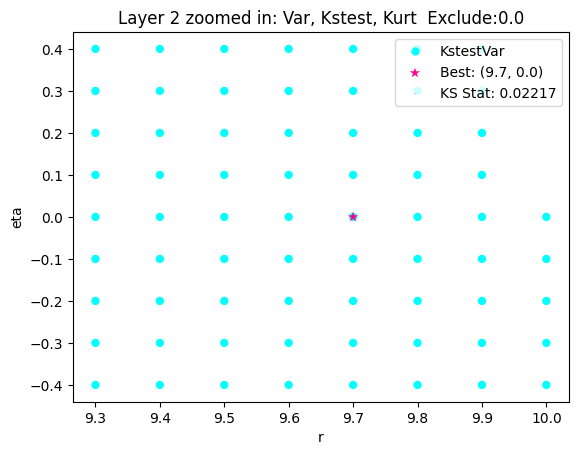

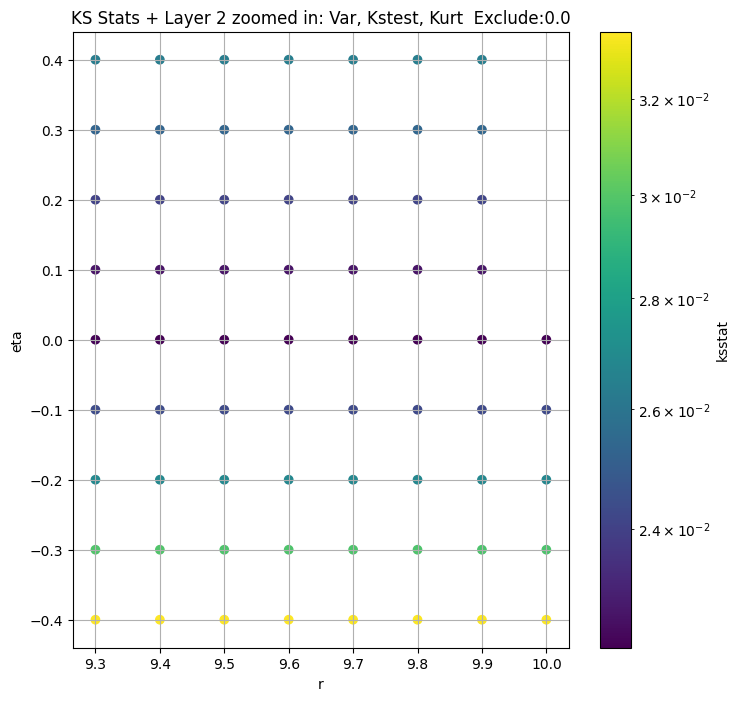

Layer 3


  0%|          | 0/270 [00:00<?, ?it/s]

Finding Minimum after computing 270 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.027347709134826204, var: 288.0969543457031


  0%|          | 0/270 [00:00<?, ?it/s]

Finding Minimum after computing 270 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.02289442132639219, var: 304.0981750488281


  0%|          | 0/270 [00:00<?, ?it/s]

Finding Minimum after computing 270 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.018616987193010193, var: 322.4530334472656


  0%|          | 0/270 [00:00<?, ?it/s]

Finding Minimum after computing 270 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.014324176380912323, var: 345.0896911621094


  0%|          | 0/270 [00:00<?, ?it/s]

Finding Minimum after computing 270 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.010336666915389425, var: 381.13232421875
Number of samples: 6416, Without approximation : 6416.0


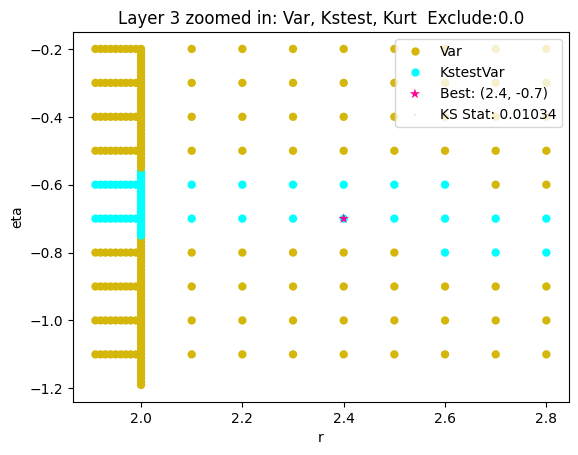

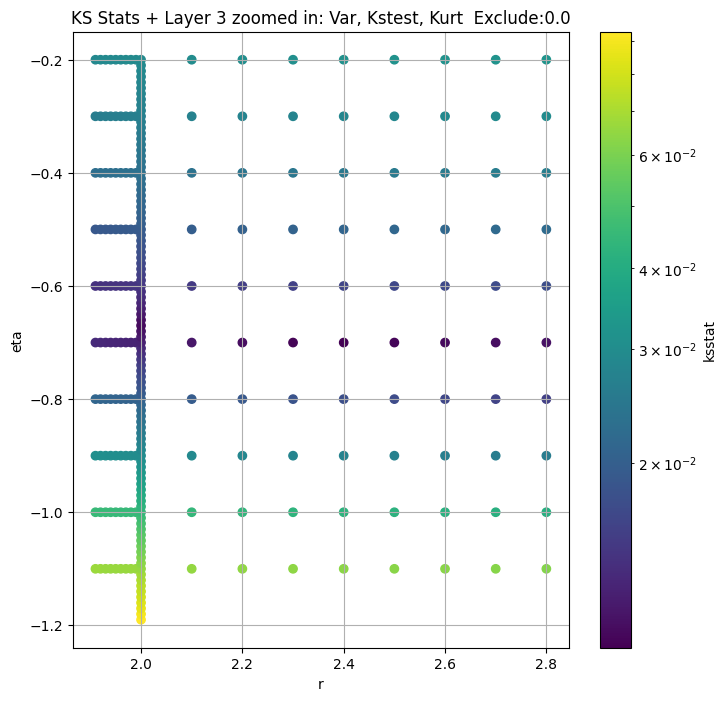

Layer 4


  0%|          | 0/510 [00:00<?, ?it/s]

Finding Minimum after computing 510 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.010553952736977235, var: 60.331050872802734


  0%|          | 0/510 [00:00<?, ?it/s]

Finding Minimum after computing 510 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.009086334742576585, var: 61.92927551269531


  0%|          | 0/510 [00:00<?, ?it/s]

Finding Minimum after computing 510 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.007461741412155498, var: 63.76028823852539


  0%|          | 0/510 [00:00<?, ?it/s]

Finding Minimum after computing 510 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.00543769621493001, var: 66.01875305175781


  0%|          | 0/510 [00:00<?, ?it/s]

Finding Minimum after computing 510 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.00408468628797487, var: 69.62678527832031
Number of samples: 25664, Without approximation : 25664.0


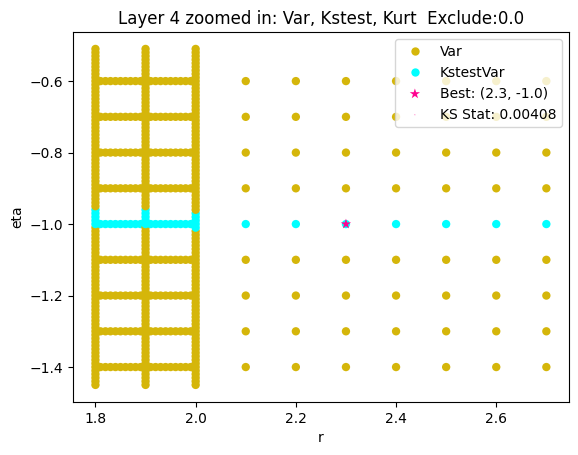

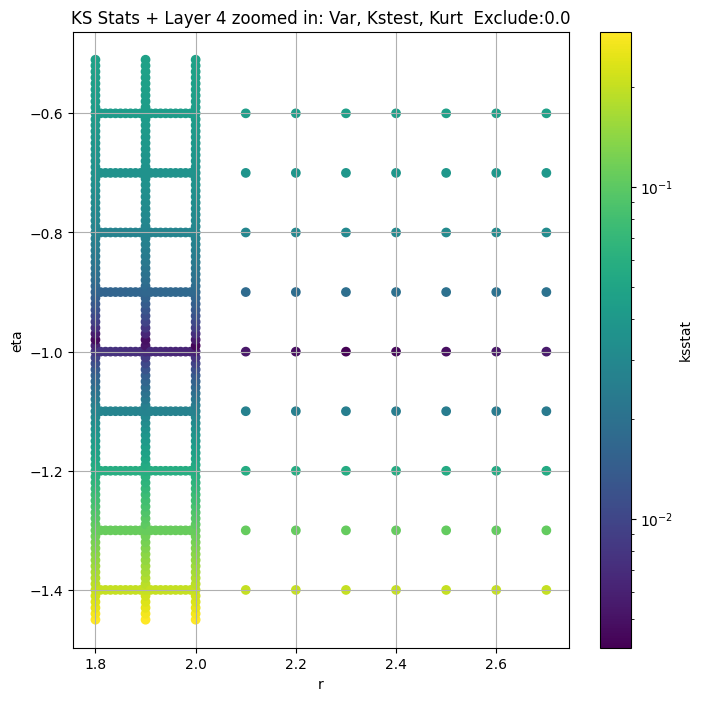

Layer 5


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 300.0 + 100 = 400, ksstat: 0.00861579605952937, var: 9.810445785522461


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 300.0 + 75 = 375, ksstat: 0.008355938909141769, var: 9.892634391784668


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 300.0 + 50 = 350, ksstat: 0.00801153987246879, var: 9.977173805236816


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 300.0 + 25 = 325, ksstat: 0.00774454153429556, var: 10.064260482788086


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 300.0 + 0 = 300, ksstat: 0.007599824092466623, var: 10.15440559387207


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 300.0 + -25 = 275, ksstat: 0.0076218205730117505, var: 10.247841835021973


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 300.0 + -50 = 250, ksstat: 0.0072454316819535805, var: 10.345102310180664


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 300.0 + -75 = 225, ksstat: 0.007285197262422938, var: 10.446284294128418


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 300.0 + -100 = 200, ksstat: 0.007133990651007949, var: 10.552773475646973
Number of samples: 100000, Without approximation : 102656.0


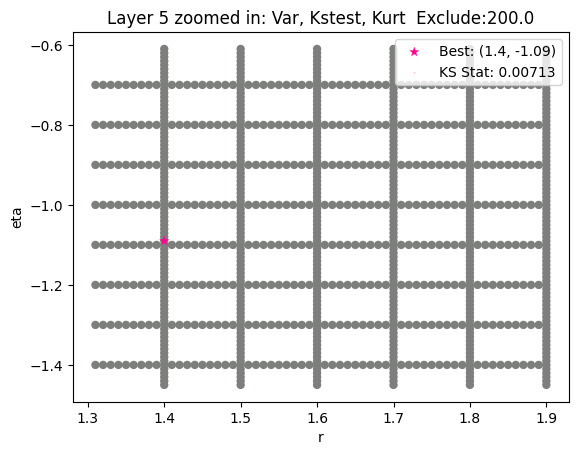

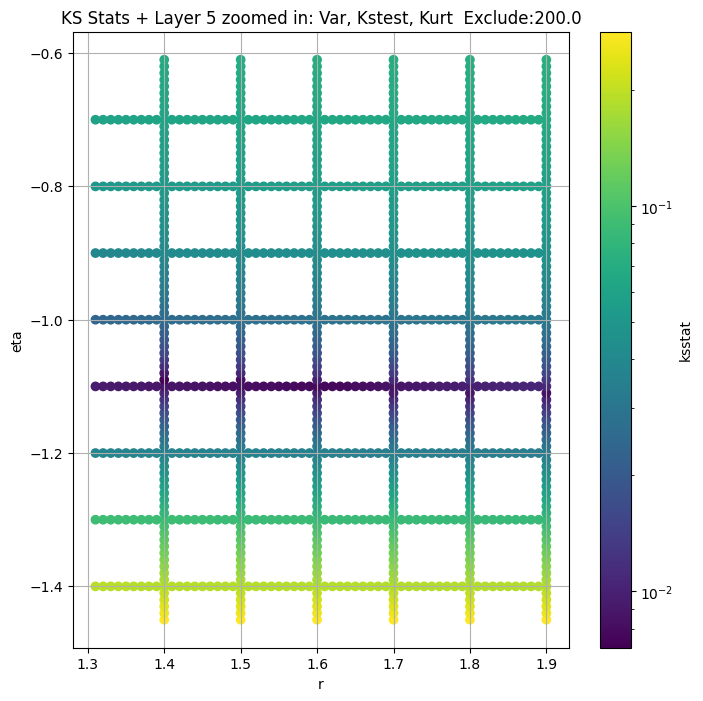

Layer 6


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 200.0 + 100 = 300, ksstat: 0.010525394570247856, var: 1.6297591924667358


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 200.0 + 75 = 275, ksstat: 0.01021746830356518, var: 1.6486445665359497


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 200.0 + 50 = 250, ksstat: 0.010029133845457394, var: 1.6683063507080078


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 200.0 + 25 = 225, ksstat: 0.009941352650938734, var: 1.6888401508331299


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 200.0 + 0 = 200, ksstat: 0.0096649923257065, var: 1.7103967666625977


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 200.0 + -25 = 175, ksstat: 0.009642545822439952, var: 1.7331666946411133


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 200.0 + -50 = 150, ksstat: 0.009726567963816268, var: 1.7574344873428345


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 200.0 + -75 = 125, ksstat: 0.009650083693334754, var: 1.7833821773529053


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 200.0 + -100 = 100, ksstat: 0.009575520635650536, var: 1.8114073276519775
Number of samples: 100000, Without approximation : 410624.0


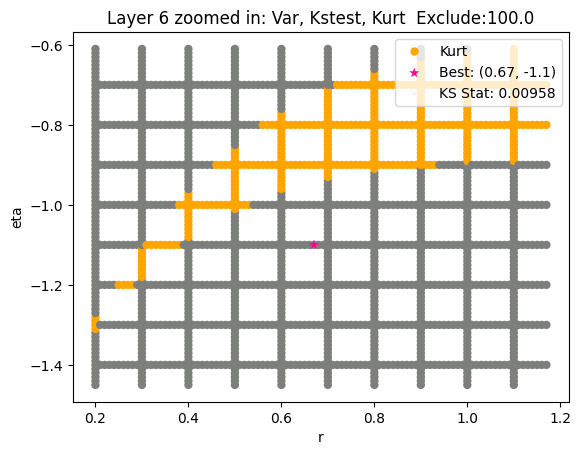

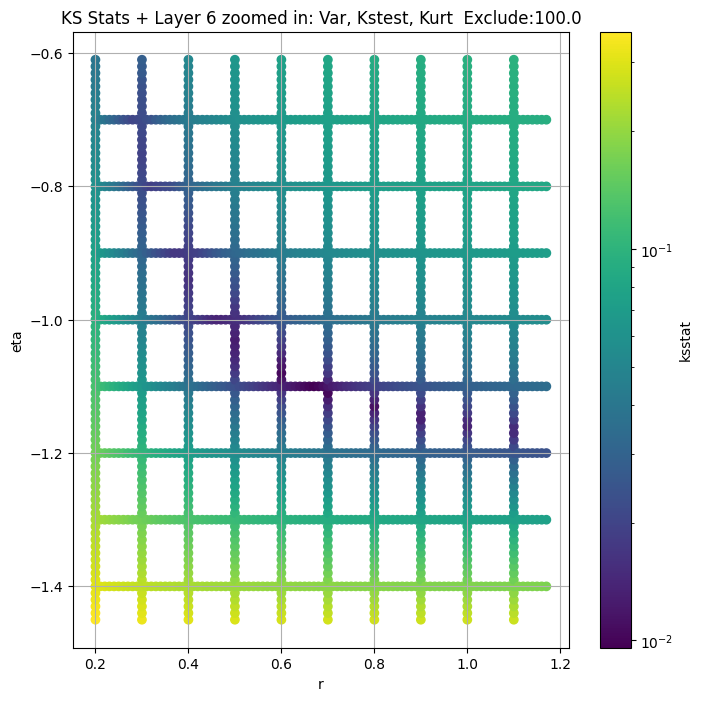

Layer 7


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 50.0 + 100 = 150, ksstat: 0.010591528529335092, var: 0.29797324538230896


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 50.0 + 75 = 125, ksstat: 0.010789226693632803, var: 0.3035847842693329


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 50.0 + 50 = 100, ksstat: 0.011520028911048752, var: 0.30973005294799805


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 50.0 + 25 = 75, ksstat: 0.011222682464534173, var: 0.3165709376335144


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 50.0 + 0 = 50, ksstat: 0.010873128278262728, var: 0.32440972328186035


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 50.0 + -25 = 25, ksstat: 0.01250896137842561, var: 0.333988219499588


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 50.0 + -50 = 0, ksstat: 0.011126382684813474, var: 0.35120442509651184
Number of samples: 100000, Without approximation : 1642496.0


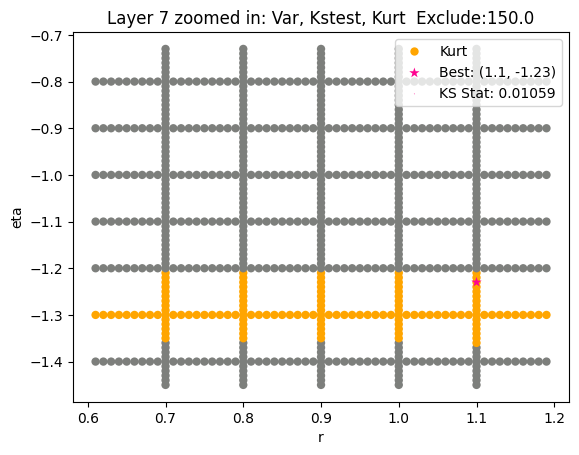

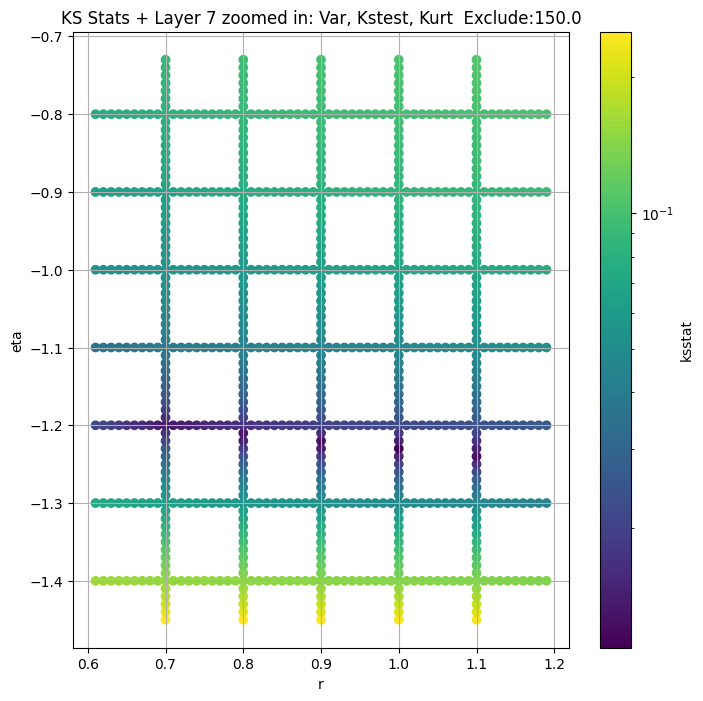

Layer 8


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.0065611466184918865, var: 0.06622404605150223


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.005687680063168658, var: 0.0681651383638382


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.005612030773677529, var: 0.0704394206404686


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.005630870642080621, var: 0.07328155636787415


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.00603974066833729, var: 0.07910505682229996
Number of samples: 100000, Without approximation : 6569984.0


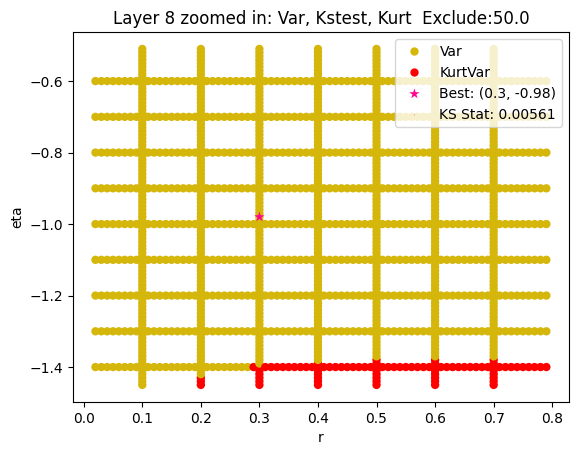

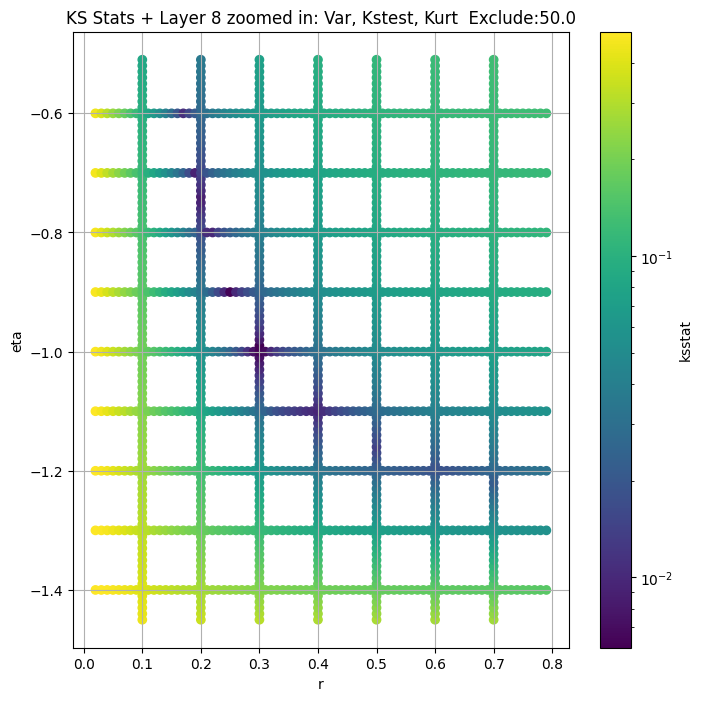

Layer 9


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 100.0 + 100 = 200, ksstat: 0.013650955586073543, var: 0.012592021375894547


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 100.0 + 75 = 175, ksstat: 0.013935017991047197, var: 0.012970990501344204


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 100.0 + 50 = 150, ksstat: 0.013445108222729152, var: 0.01338547095656395


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 100.0 + 25 = 125, ksstat: 0.013119896064153203, var: 0.013843939639627934


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 100.0 + 0 = 100, ksstat: 0.013249466264369292, var: 0.014358852058649063


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 100.0 + -25 = 75, ksstat: 0.013582906936462358, var: 0.014950744807720184


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 100.0 + -50 = 50, ksstat: 0.01418776172273295, var: 0.015655824914574623


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 100.0 + -75 = 25, ksstat: 0.014677802901725712, var: 0.016560612246394157


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 100.0 + -100 = 0, ksstat: 0.01585862117836434, var: 0.01855897158384323
Number of samples: 100000, Without approximation : 26279936.0


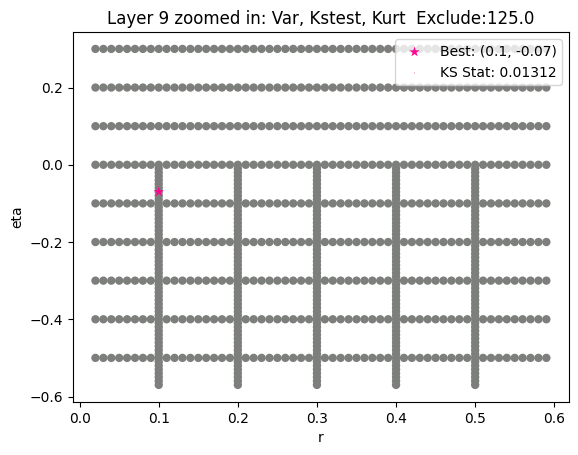

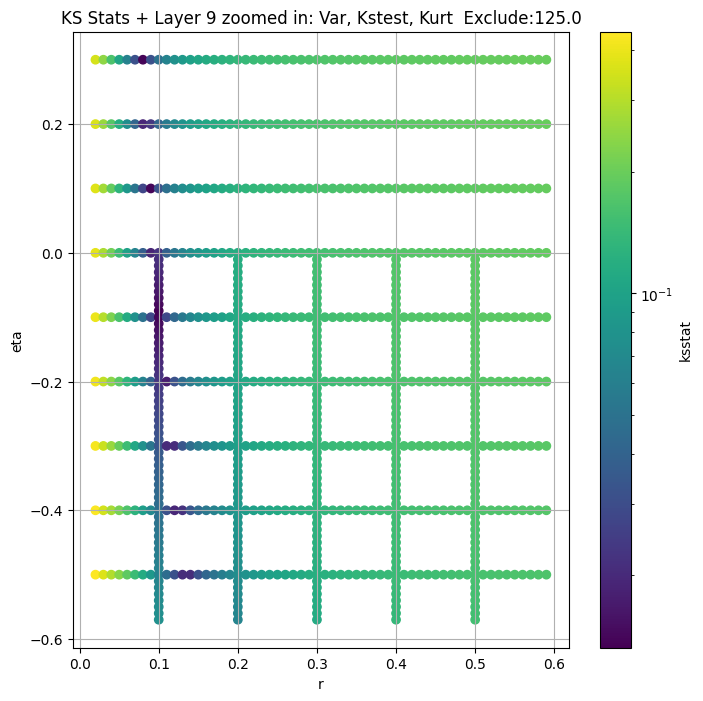

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1722.312600  1556.518900  1894.537500   0.296366   -0.065850   
3       381.132320   358.688500   404.139500   1.417218    1.040942   
4        69.626785    65.514710    73.893234   3.422446    2.709257   
5        11.818949    11.006219    12.672133   5.558610    4.478826   
6         1.986774     1.822651     2.164862   9.345805    6.891265   
7         0.351204     0.315624     0.395142  16.423952   10.114853   
8         0.079105     0.068840     0.093627  32.942100   15.381708   
9         0.018559     0.015405     0.023803  68.993180   25.134613   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.712099         1604.0             0.022171        9.7          0.0   
3        1.866860         6416.0             0.010337        2.4         -0.7   
4        4.306627        25664.0             0.004085        2.3         -1.0   
5        7.095064       102656.0             0.007628        1.8         -1.1   
6       14.922341       410624.0             0.009665        0.7         -1.1   
7       44.308070      1642496.0             0.013143        0.7         -1.2   
8      111.845790      6569984.0             0.006187        0.3         -1.0   
9      257.763280     26279936.0             0.013972        0.1         -0.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.955160e+03                     0.0         1722.312600   
3       8.332105e+02                     0.0          381.132320   
4       2.119636e+02                     0.0           69.626785   
5       3.503746e+01                   300.0           10.552773   
6       2.665792e+00                   200.0            1.811407   
7       7.076605e-01                    50.0            0.297973   
8       2.975488e-03                     0.0            0.070439   
9       3.458642e-15                   100.0            0.013844   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.022171    9.70      0.00   
3                     0.016929          0.010337    2.40     -0.70   
4                     0.008471          0.004085    2.30     -1.00   
5                     0.004237          0.007134    1.40     -1.09   
6                     0.002119          0.009576    0.67     -1.10   
7                     0.001060          0.010592    1.10     -1.23   
8                     0.000530          0.005612    0.30     -0.98   
9                     0.000265          0.013120    0.10     -0.07   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      2.955160e+03                  0.0         3609  
3      8.332105e+02                  0.0        18270  
4      2.119636e+02                  0.0       109623  
5      3.251179e+01                200.0        36540  
6      2.602709e+00                100.0        19248  
7      1.182427e+00                150.0        16240  
8      2.428765e-03                 50.0        57744  
9      2.827833e-15                125.0        10827

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

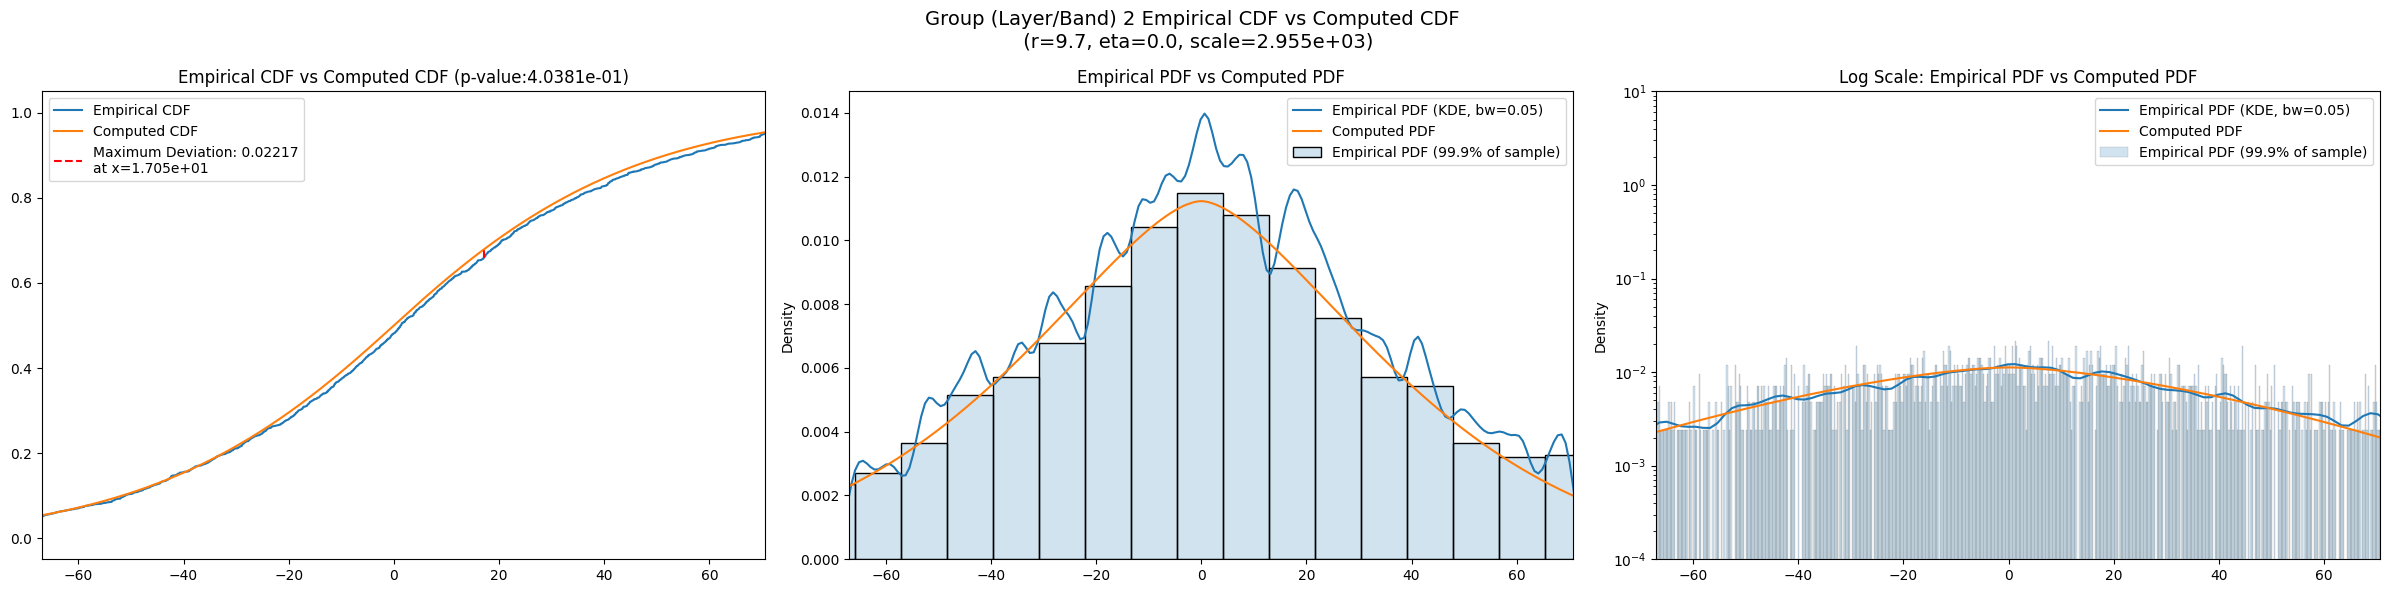

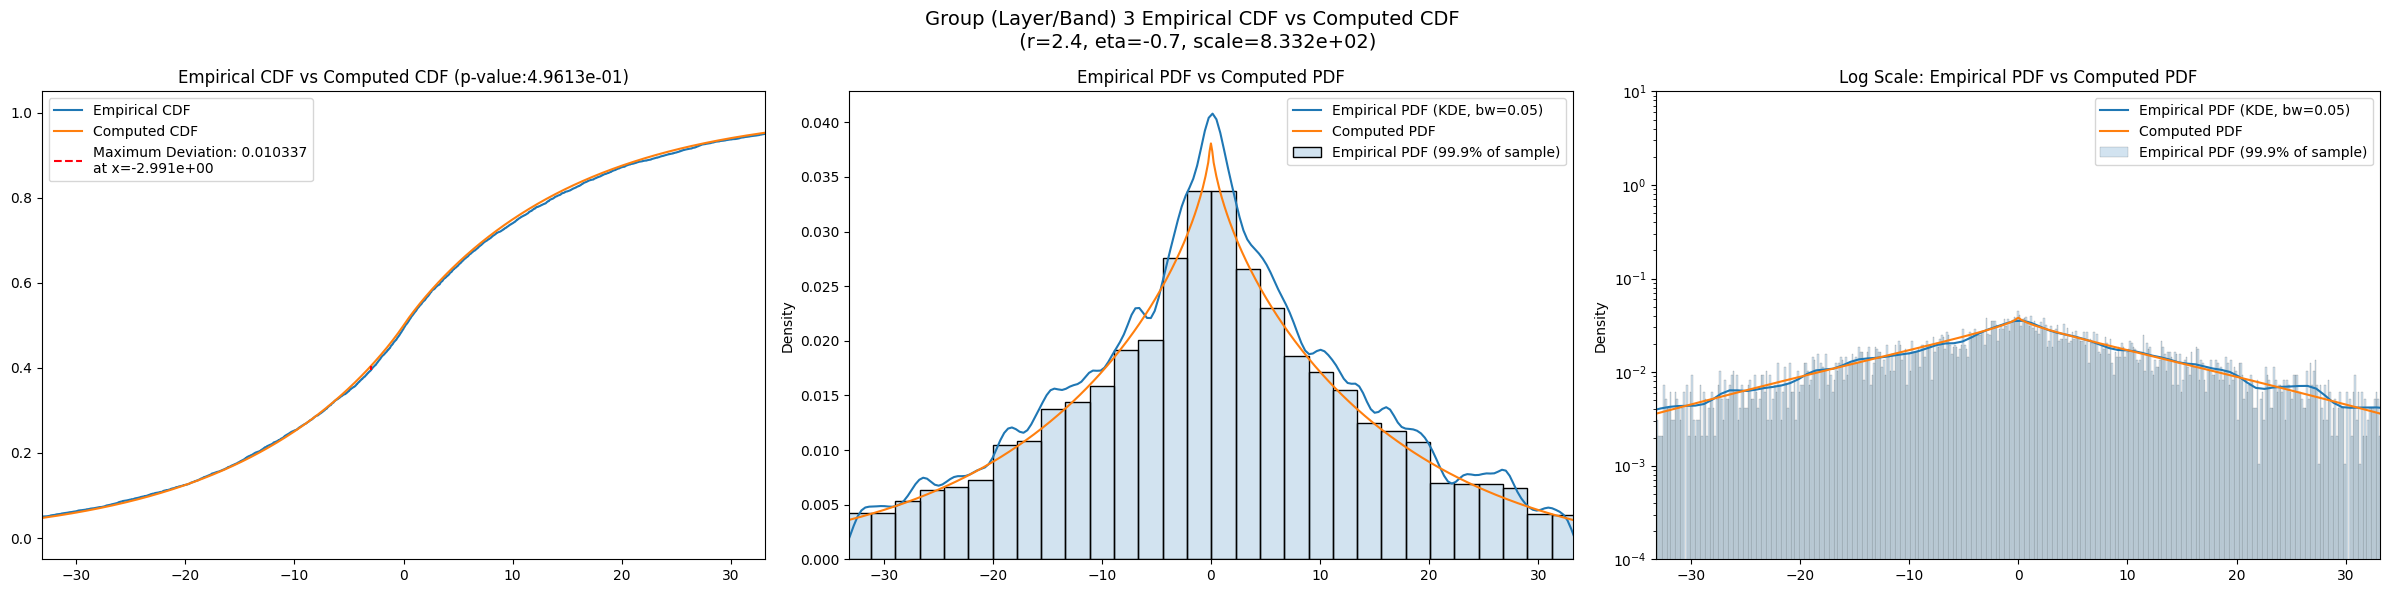

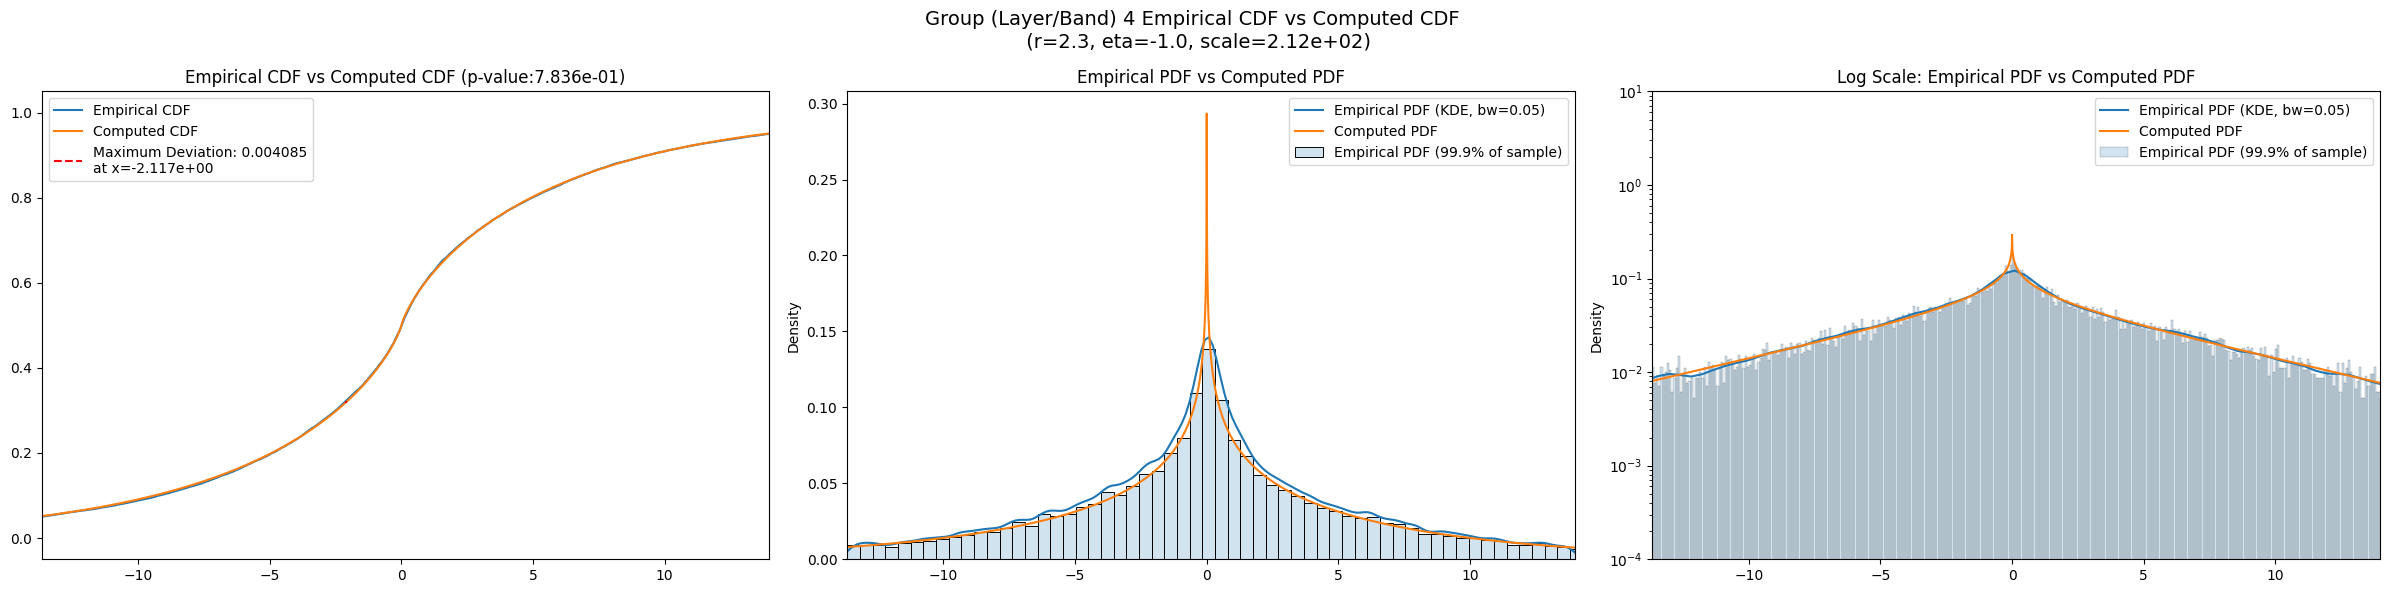

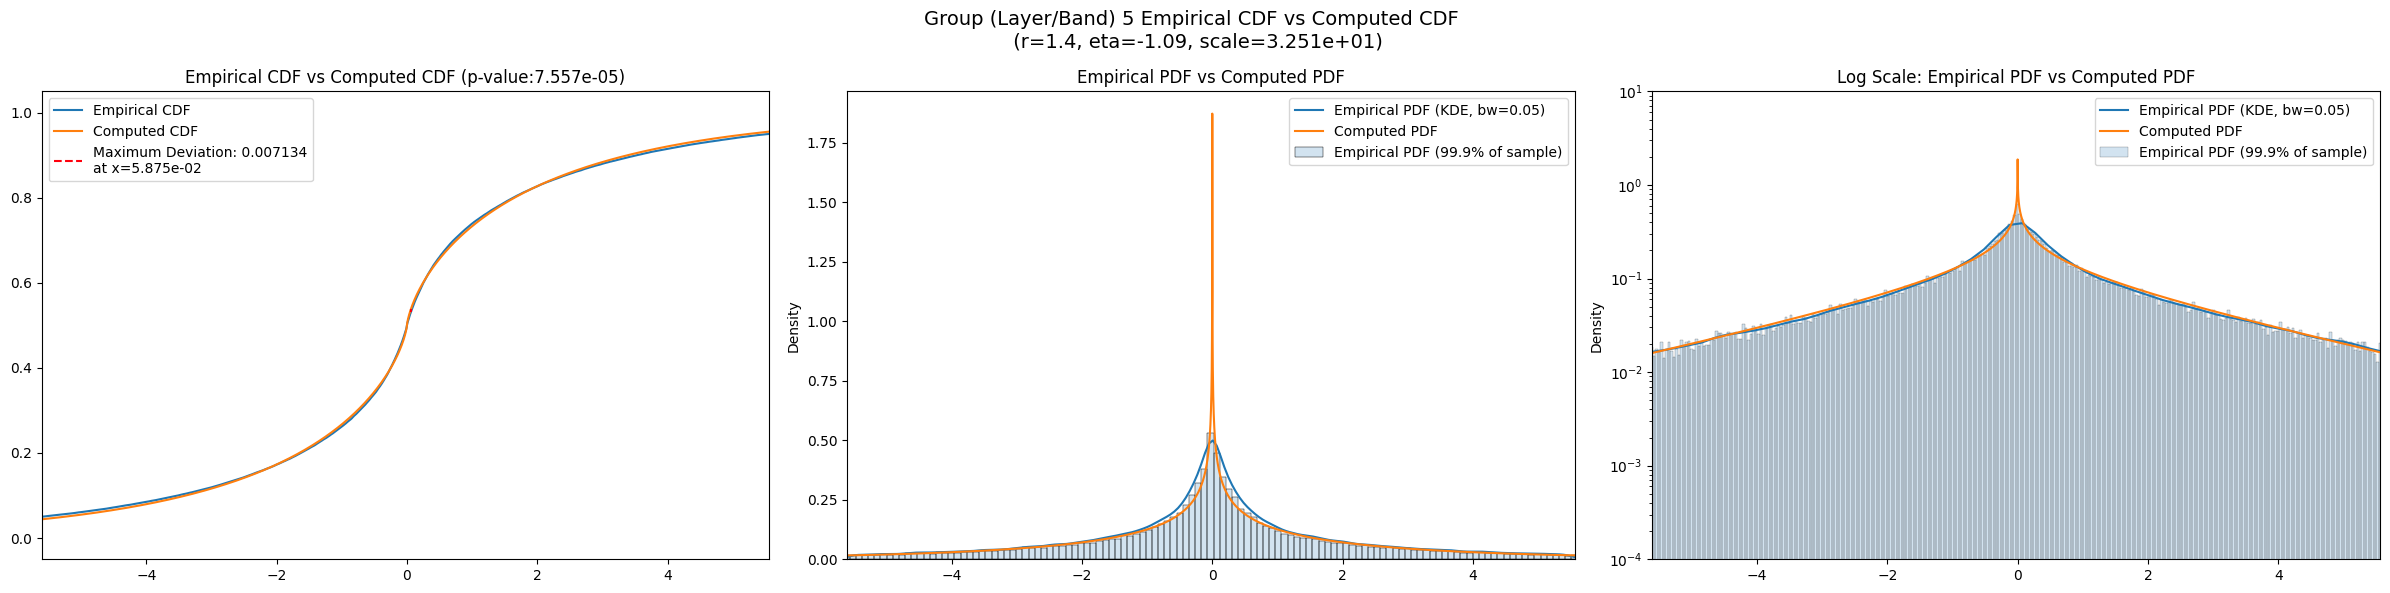

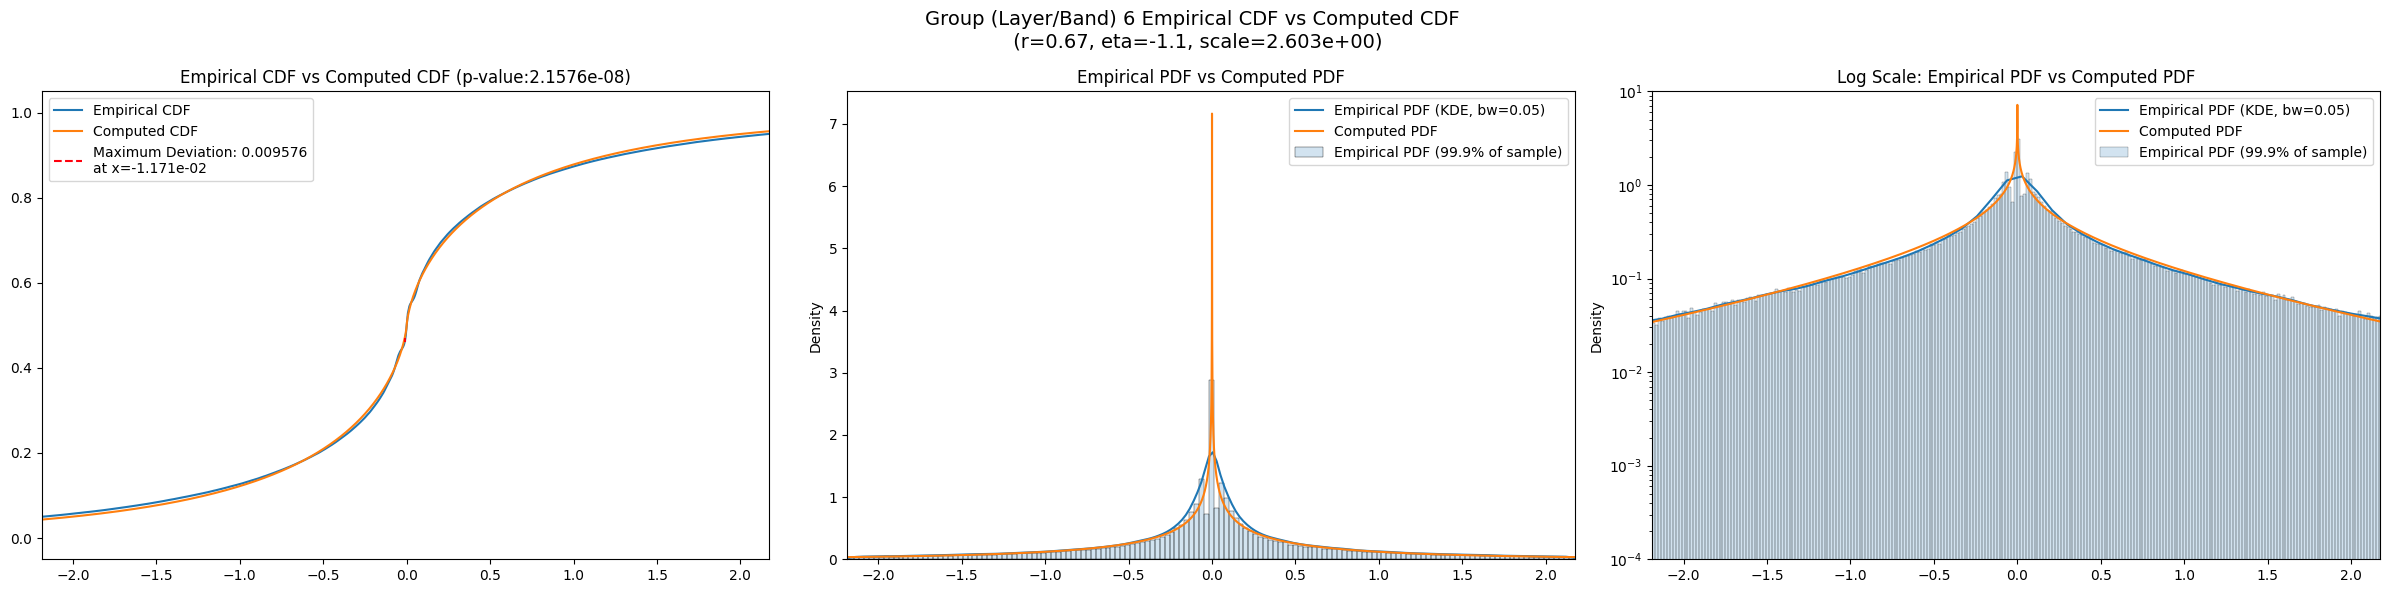

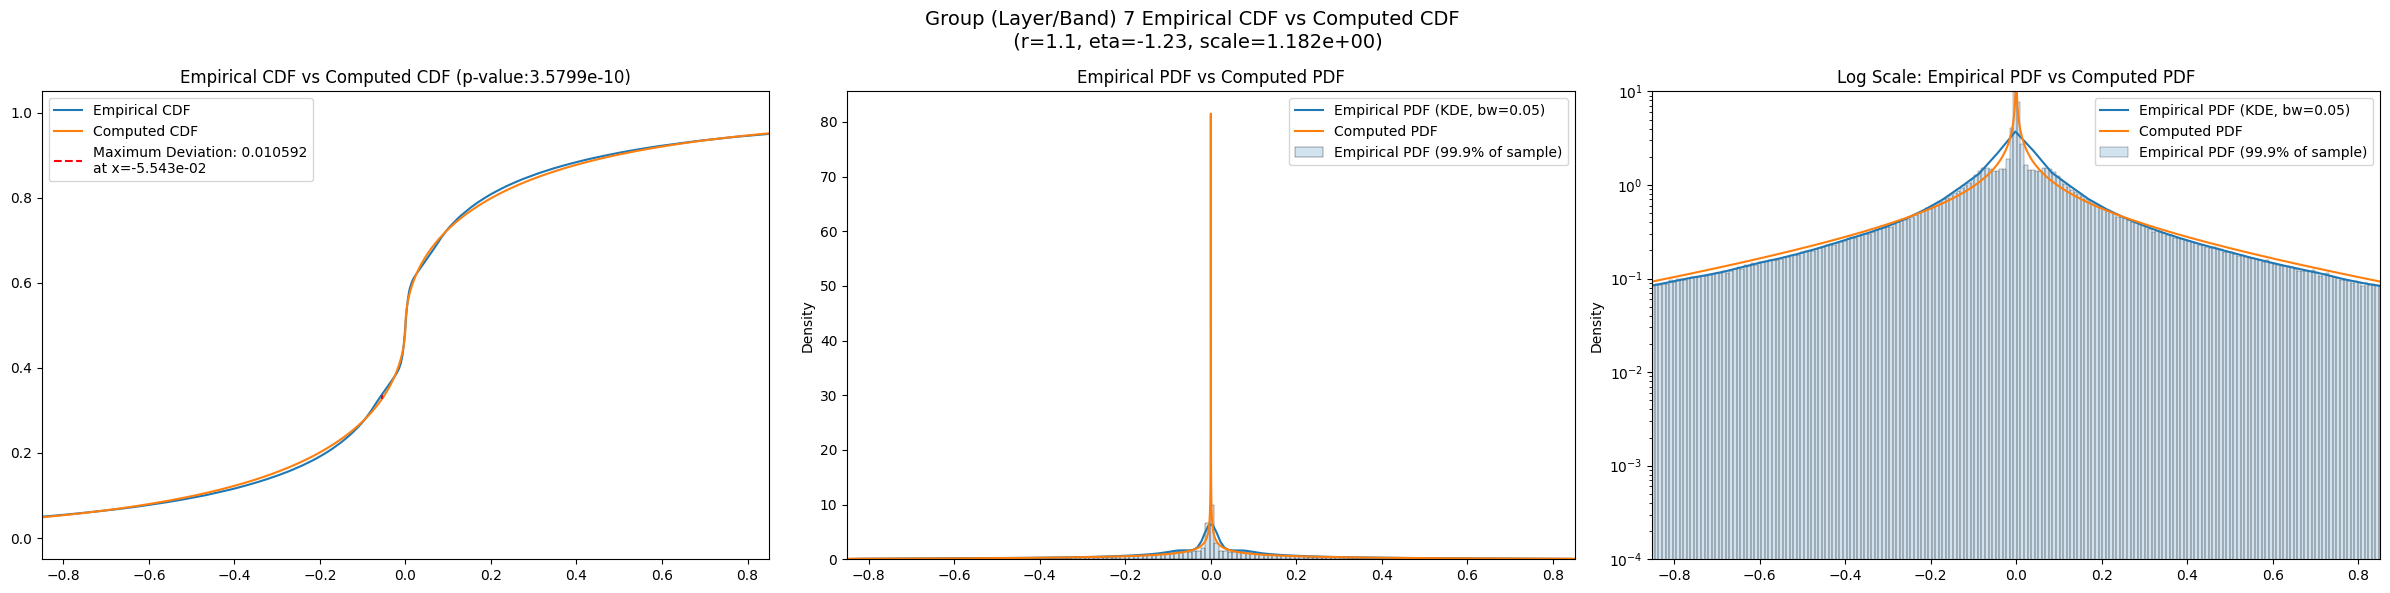

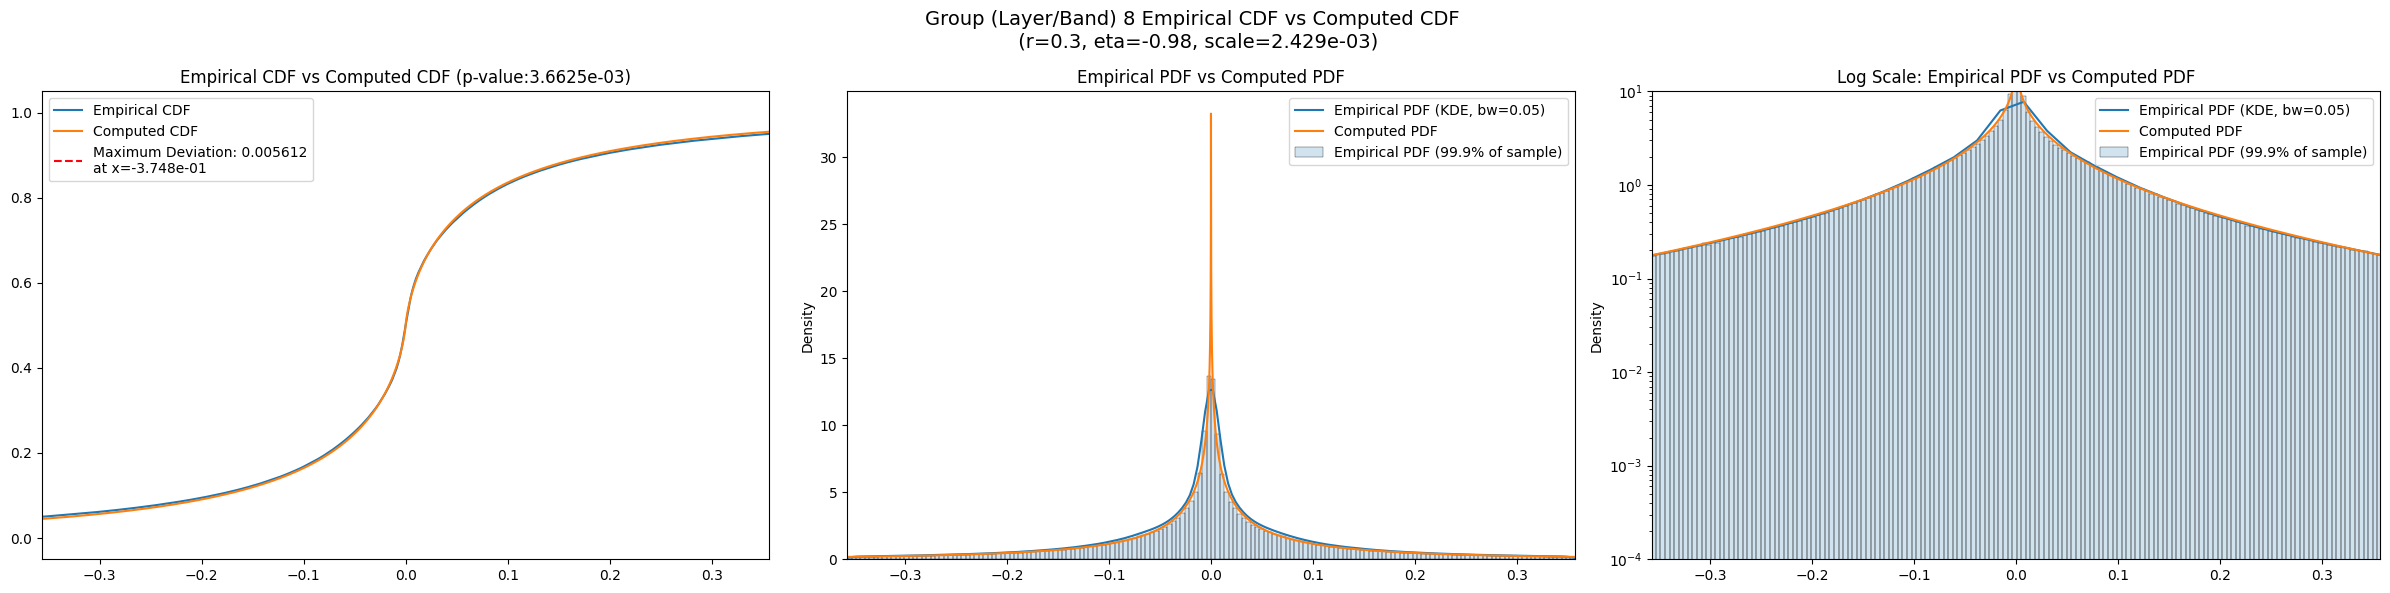

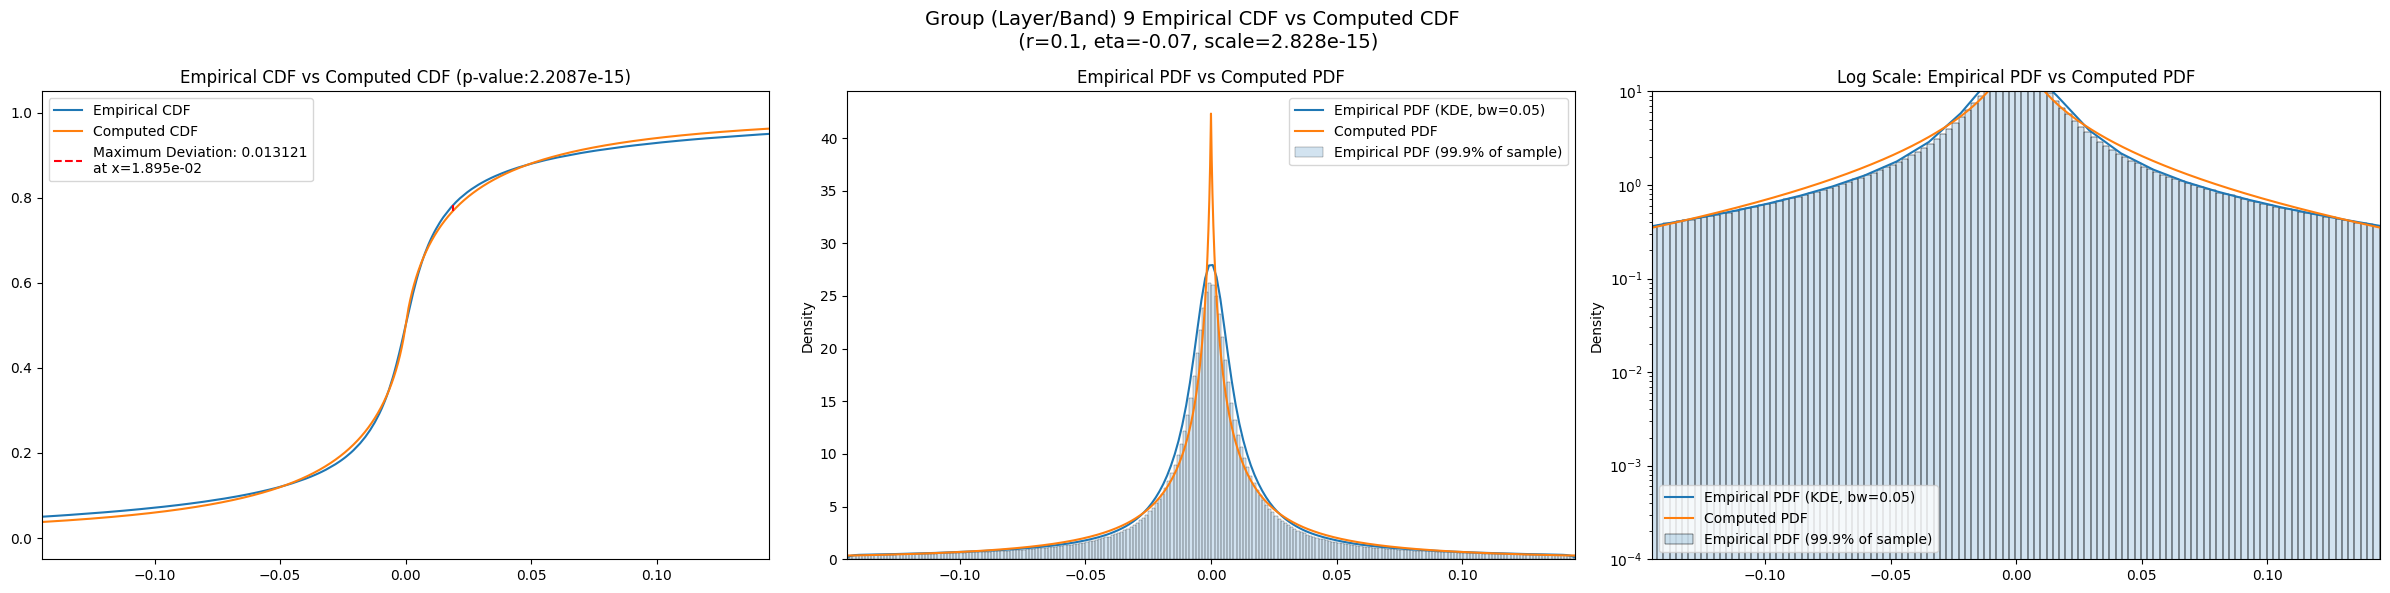

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1722.312600  1556.518900  1894.537500   0.296366   -0.065850   
3       381.132320   358.688500   404.139500   1.417218    1.040942   
4        69.626785    65.514710    73.893234   3.422446    2.709257   
5        11.818949    11.006219    12.672133   5.558610    4.478826   
6         1.986774     1.822651     2.164862   9.345805    6.891265   
7         0.351204     0.315624     0.395142  16.423952   10.114853   
8         0.079105     0.068840     0.093627  32.942100   15.381708   
9         0.018559     0.015405     0.023803  68.993180   25.134613   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.712099         1604.0             0.022171        9.7          0.0   
3        1.866860         6416.0             0.010337        2.4         -0.7   
4        4.306627        25664.0             0.004085        2.3         -1.0   
5        7.095064       102656.0             0.007628        1.8         -1.1   
6       14.922341       410624.0             0.009665        0.7         -1.1   
7       44.308070      1642496.0             0.013143        0.7         -1.2   
8      111.845790      6569984.0             0.006187        0.3         -1.0   
9      257.763280     26279936.0             0.013972        0.1         -0.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       38.588000              0.028282          1.507470e-01   
3      ...       16.123100              0.034238          5.714430e-07   
4      ...        5.898340              0.047804          2.095010e-51   
5      ...        2.003250              0.062960          0.000000e+00   
6      ...        0.657761              0.075329          0.000000e+00   
7      ...        0.235667              0.077975          0.000000e+00   
8      ...        0.095476              0.077054          0.000000e+00   
9      ...        0.032260              0.080515          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          36.504000             0.031752         7.710160e-02  29.399800   
3          14.360300             0.011827         3.281510e-01  11.959000   
4           5.102780             0.021260         1.654880e-10   4.196340   
5           1.725600             0.036653        2.939620e-120   1.381320   
6           0.567006             0.049259         0.000000e+00   0.446521   
7           0.183411             0.062260         0.000000e+00   0.142078   
8           0.081459             0.053183         0.000000e+00   0.062562   
9           0.028978             0.056027         0.000000e+00   0.022315   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.033849   4.952090e-02          4.037556e-01  
3           0.018765   2.153910e-02          4.961309e-01  
4           0.027038   9.867280e-17          7.835970e-01  
5           0.040009  3.236330e-143          5.766749e-05  
6           0.050639   0.000000e+00          3.934798e-33  
7           0.064278   0.000000e+00         1.799903e-160  
8           0.054087   0.000000e+00         3.716876e-180  
9           0.051342   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.022171                 0.033804          0.022171   
3                 0.010337                 0.016929          0.010337   
4                 0.004085                 0.008471          0.004085   
5                 0.007628                 0.004237          0.007134   
6                 0.009665                 0.002119          0.009576   
7                 0.013143                 0.001060          0.010592   
8                 0.006187                 0.000530          0.005612   
9                 0.013972                 0.000265          0.013120   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.028282             0.031752       0.033849  
3                  0.034238             0.011827       0.018765  
4                  0.047804             0.021260       0.027038  
5                  0.062960             0.036653       0.040009  
6                  0.075329             0.049259       0.050639  
7                  0.077975             0.062260       0.064278  
8                  0.077054             0.053183       0.054087  
9                  0.080515             0.056027       0.051342

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             1722.312600          0.022171    9.70      0.00  2.955160e+03   
3              381.132320          0.010337    2.40     -0.70  8.332105e+02   
4               69.626785          0.004085    2.30     -1.00  2.119636e+02   
5               10.552773          0.007134    1.40     -1.09  3.251179e+01   
6                1.811407          0.009576    0.67     -1.10  2.602709e+00   
7                0.297973          0.010592    1.10     -1.23  1.182427e+00   
8                0.070439          0.005612    0.30     -0.98  2.428765e-03   
9                0.013844          0.013120    0.10     -0.07  2.827833e-15   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                    200.0  
6                    100.0  
7                    150.0  
8                     50.0  
9                    125.0